In [122]:
import pandas as pd
from graph_traffic.merge_data import merge_data
from graph_traffic.get_data import get_mmagns
from graph_traffic.custom_transformer import get_column_names, transform_df
from graph_traffic.config import project_path
from graph_traffic.model_selection import get_node_ids
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from datetime import date, datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from graph_traffic.get_data import get_data
from graph_traffic.config import figures_path, project_path
from graph_traffic.dataloading import npzDataset
from graph_traffic.baseline_models import DaytimeRegressor

train_until = date(2021, 11, 30)

start = 100
periods_to_show = 4*24*2

ids_to_use = get_node_ids()[1:2]
#ids_to_use = [5100]

data_dict = dict(
    ids_list=ids_to_use,  #[1001],#[3532, 3542, 3544, 3545, 3546, 3577, 3637, 3640, 3641, 4761, 4763],
    seq_len=4 * 24,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2021-12-31",
    dataset_name="small",
    target="ocupacion",
    interactions="drop"
)

meteo_dict = {
    'rain': 'numerico_power',
    'wind': 'drop',
    'temperature': 'passthrough',
    'humidity': 'passthrough',
    'pressure': 'drop',
    'radiation': 'passthrough'
}
mmagns = get_mmagns(meteo_dict)

temporal_dict = {
    'year': 'passthrough',
    'season': 'ordinal',
    'month': 'passthrough',
    'day_of_month': 'passthrough',
    'weekday': 'drop',
    'hour': 'one_hot',
    'minute': 'drop',
    'bank_holiday': 'passthrough',
    'school_holiday': 'drop',
    'working_day': 'passthrough',
    'state_of_alarm': 'passthrough'
}

## Load data for XGBoost and first regression

In [123]:
node_id = ids_to_use[0]
dfs_dict = dict()
df = merge_data(node_id, data_dict["from_date"], data_dict["to_date"], data_dict["target"], mmagns)
df = transform_df(df, meteo_dict, temporal_dict, data_dict["interactions"], data_dict["target"])
train_data_size = df[(df[:, 28] <= 2020) |
                     ((df[:, 30] <= train_until.month) & (
                             df[:, 31] <= train_until.day))].shape[0]
test_data_size = df[(df[:, 28] >= 2020) &
                    ((df[:, 30] >= train_until.month) & (
                            df[:, 31] >= train_until.day)) &
                    ((df[:, 30] <= train_until.month + 1) & (
                            df[:, 31] <= 31))
                    ].shape[0]
train_x = df[:train_data_size, 1:]
train_y = df[:train_data_size, 0].ravel()

test_x = df[train_data_size:train_data_size + test_data_size, 1:]
test_y = df[train_data_size:train_data_size + test_data_size, 0].ravel()

In [124]:
test_x

array([[  0.   ,   0.   ,   0.   , ...,   4.425,  82.25 ,   0.   ],
       [  1.   ,   0.   ,   0.   , ...,   4.3  ,  82.   ,   0.   ],
       [  1.   ,   0.   ,   0.   , ...,   4.15 ,  83.   ,   0.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ...,  14.875,  47.75 , 449.5  ],
       [  0.   ,   0.   ,   0.   , ...,  14.9  ,  48.   , 433.   ],
       [  0.   ,   0.   ,   0.   , ...,  14.85 ,  48.   , 372.   ]])

# Train first regression

In [125]:
reg1 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("RidgeRegression", RidgeCV())
])
reg1.fit(train_x, train_y)
reg1_pred = reg1.predict(test_x[start:start+periods_to_show])

# Train XGBoost

In [126]:
with open(f"{project_path}/training_history/xgboost/bestparams.pkl", "rb") as f:
    best_params = pickle.load(f)

reg = xgb.XGBRegressor(
    n_estimators=best_params["n_estimators"][node_id],
    max_depth=best_params["max_depth"][node_id],
    min_child_weight=best_params["min_child_weight"][node_id],
    gamma=best_params["gamma"][node_id],
    subsample=best_params["subsample"][node_id],
    colsample_bytree=best_params["colsample_bytree"][node_id],
    reg_alpha=best_params["reg_alpha"][node_id],
    reg_lambda=best_params["reg_lambda"][node_id],
    learning_rate=best_params["learning_rate"][node_id]
)
reg.fit(train_x, train_y)
xgb_pred = reg.predict(test_x[start:start+periods_to_show])

# Load data for second regression

In [127]:
data_dict = dict(
    ids_list=ids_to_use,
    seq_len=4*24,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2021-12-31",
    dataset_name="small",
    target="ocupacion",
    interactions="drop"
)

meteo_dict = {
    'rain': 'ordinal',
    'wind': 'drop',
    'temperature': 'passthrough',
    'humidity': 'passthrough',
    'pressure': 'drop',
    'radiation': 'passthrough'
}

temporal_dict= {
    'year': 'passthrough',
    'season': 'ordinal',
    'month': 'passthrough',
    'day_of_month': 'fourier',
    'weekday': 'passthrough',
    'hour': 'spline',
    'minute': 'passthrough',
    'bank_holiday': 'passthrough',
    'school_holiday': 'drop',
    'working_day': 'passthrough',
    'state_of_alarm': 'passthrough'
}

node_id = ids_to_use[0]
df = merge_data(node_id, data_dict["from_date"], data_dict["to_date"], data_dict["target"], mmagns)
df = transform_df(df, meteo_dict, temporal_dict, data_dict["interactions"], data_dict["target"])
train_x = df[:train_data_size, 1:]
train_y = df[:train_data_size, 0].ravel()

test_x = df[train_data_size:train_data_size + test_data_size, 1:]
reg2 = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("RidgeRegression", RidgeCV())
])
reg2.fit(train_x, train_y)
reg2_pred = reg2.predict(test_x[start:start+periods_to_show])

# Load data for baseline models: median/mean per hour with working day

In [128]:
data_dict = dict(
    ids_list=ids_to_use,#[3954, 3973, 3976, 3977, 3978],#[3532, 3542, 3544, 3545, 3546, 3577, 3637, 3640, 3641, 4761, 4763],
    seq_len=4*24,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2021-12-31",
    dataset_name="small",
    target="ocupacion",
    interactions="drop"
)

meteo_dict = {
    'rain': 'numerico_power',
    'wind': 'drop',
    'temperature': 'passthrough',
    'humidity': 'passthrough',
    'pressure': 'drop',
    'radiation': 'passthrough'
}

temporal_dict = dict(
    year="drop",
    season="drop",
    month="drop",
    day_of_month="drop",
    weekday="drop",
    hour="passthrough",
    minute="drop",
    bank_holiday="drop",
    school_holiday="drop",
    working_day="passthrough",
    state_of_alarm="drop"
)
dnode_id = ids_to_use[0]
df = merge_data(node_id, data_dict["from_date"], data_dict["to_date"], data_dict["target"], mmagns)
df = transform_df(df, meteo_dict, temporal_dict, data_dict["interactions"], data_dict["target"])
train_x = df[:train_data_size, :3]
train_y = df[:train_data_size, :3]
test_x = df[train_data_size:train_data_size+test_data_size, :3]
df = df[:, :3]

In [129]:
hours = list(test_x[start:start+periods_to_show, 1]).copy()
for j, t in enumerate(hours[1:]):
    while hours[j] > hours[j+1]:
        hours[j+1] = hours[j+1] + 24

In [130]:
# mean_df = pd.DataFrame(train_y[:, :3]).groupby([1, 2]).mean().reset_index()
# mean_ww_pred = pd.DataFrame(test_x[start:start+periods_to_show, [1, 2]]).merge(mean_df, left_on=[0, 1], right_on=[1, 2])["0_y"]

In [131]:
#pd.DataFrame(test_x[start:start+periods_to_show, [1, 2]]).merge(mean_df, left_on=[0, 1], right_on=[1, 2])

# Visualize results

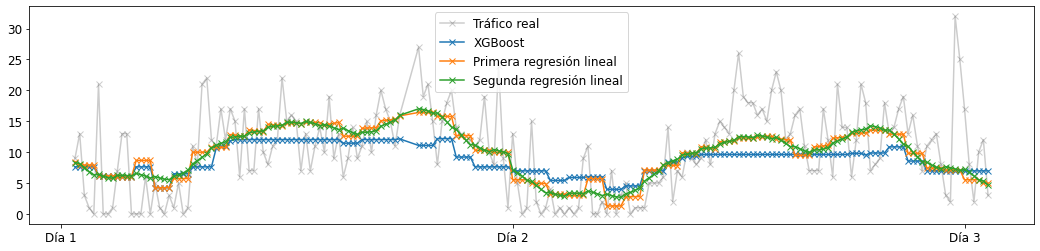

In [132]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(
    hours,
    test_y[start:start+periods_to_show],
    "x-",
    alpha=0.2,
    label="Tráfico real",
    color="black")

ax.plot(
    hours,
    xgb_pred,
    "x-",
    label="XGBoost"
)

ax.plot(
    hours,
    reg1_pred,
    "x-",
    label="Primera regresión lineal"
)

ax.plot(
    hours,
    reg2_pred,
    "x-",
    label="Segunda regresión lineal"
)

# ax.plot(
#     hours,
#     mean_ww_pred,
#     "x-",
#     label="Media por hora y tipo de día"
# )
ax.set_xticks([0, 24, 48])
ax.set_xticklabels(["Día 1", "Día 2", "Día 3"])

_ = ax.legend()

In [103]:
hours

[0.0,
 0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0,
 4.25,
 4.5,
 4.75,
 5.0,
 5.25,
 5.5,
 5.75,
 6.0,
 6.25,
 6.5,
 6.75,
 7.0,
 7.25,
 7.5,
 7.75,
 8.0,
 8.25,
 8.5,
 8.75,
 9.0,
 9.25,
 9.5,
 9.75,
 10.0,
 10.25,
 10.5,
 10.75,
 11.0,
 11.25,
 11.5,
 11.75,
 12.0,
 12.25,
 12.5,
 12.75,
 13.0,
 13.25,
 13.5,
 13.75,
 14.0,
 14.25,
 14.5,
 14.75,
 15.0,
 15.25,
 15.5,
 15.75,
 16.0,
 16.25,
 16.5,
 16.75,
 17.0,
 17.25,
 17.5,
 17.75,
 18.0,
 18.25,
 18.5,
 18.75,
 19.0,
 19.25,
 19.5,
 19.75,
 20.0,
 20.25,
 20.5,
 20.75,
 21.0,
 21.25,
 21.5,
 21.75,
 22.0,
 22.25,
 22.5,
 22.75,
 23.0,
 23.25,
 23.5,
 23.75,
 24.0,
 24.25,
 24.5,
 24.75,
 25.0,
 25.25,
 25.5,
 25.75,
 26.0,
 26.25,
 26.5,
 26.75,
 27.0,
 27.25,
 27.5,
 27.75,
 28.0,
 28.25,
 28.5,
 28.75,
 29.0,
 29.25,
 29.5,
 29.75,
 30.0,
 30.25,
 30.5,
 30.75,
 31.0,
 31.25,
 31.5,
 31.75,
 32.0,
 32.25,
 32.5,
 32.75,
 33.0,
 33.25,
 33.5,
 33.75,
 34.0,
 34.25,
 34.5